## Setup

Before we begin, please make sure you have setup the `.env` file in the project 
directory as described in [`README.md`](README.md).

Next, we will load in the necessary environment variables (e.g., API keys) for this notebook:

In [1]:
import os
from dotenv import load_dotenv

_ = load_dotenv()

assert os.environ.get("GOOGLE_API_KEY")

## Data Ingestion

### Partioning and Chunking

In [3]:
from unstructured.ingest.v2.pipeline.pipeline import Pipeline
from unstructured.ingest.v2.interfaces import ProcessorConfig
from unstructured.ingest.v2.processes.connectors.local import (
    LocalIndexerConfig,
    LocalDownloaderConfig,
    LocalConnectionConfig,
    LocalUploaderConfig
)
from unstructured.ingest.v2.processes.partitioner import PartitionerConfig
from unstructured.ingest.v2.processes.chunker import ChunkerConfig


def create_data_ingestion_pipeline(
    input_pdf_path: str,
    output_dir: str,
    image_output_dir: str,
) -> Pipeline:
    """
    Creates a data ingestion pipeline. 
    
    The data ingestion pipeline runs the 
    following tasks:
    1. Loads in a PDF document.
    2. Partitions the PDF using Unstructured's `hi_res` 
       strategy into elements (text, tables, images).
    3. Chunks the PDF by title.
    4. Writes the partitioned and chunked elements 
       into a JSON file.

    Args:
        input_pdf_path: Path to the PDF document.
        output_dir: Path to directory to write the results to.
        image_output_dir: Path to directory to save the 
            extracted images to.

    Returns:
        A data ingestion pipeline that can be run.
    """
    return Pipeline.from_configs(
        context=ProcessorConfig(
            verbose=True,
            tqdm=True,
        ),
        indexer_config=LocalIndexerConfig(
            input_path=input_pdf_path,
        ),
        downloader_config=LocalDownloaderConfig(),
        source_connection_config=LocalConnectionConfig(),
        partitioner_config=PartitionerConfig(
            partition_by_api=False,
            strategy="hi_res",        
            additional_partition_args={
                "languages": ["eng"],            
                "extract_images_in_pdf": True,
                "extract_image_block_types": ["Image", "Table"],
                "extract_image_block_output_dir": image_output_dir,
            }
        ),
        chunker_config=ChunkerConfig(
            chunking_strategy="by_title",
            # Chunking params to aggregate text blocks
            # Attempt to create a new chunk 3800 chars
            # Attempt to keep chunks > 2000 chars
            chunk_max_characters=4000,
            chunk_new_after_n_chars=3800,
            chunk_combine_text_under_n_chars=2000
        ),
        uploader_config=LocalUploaderConfig(
            output_dir=output_dir,
        ),
    )

In [5]:
ingest_pipeline = create_data_ingestion_pipeline(
    input_pdf_path="data/input-docs/LLaVA-subset.pdf",
    output_dir="data/ingest-output/",
    image_output_dir="data/ingest-output/images",
)

2024-07-19 11:35:24,289 MainProcess INFO     Created index with configs: {"input_path": "data/input-docs/LLaVA-subset.pdf", "recursive": false, "file_glob": null}, connection configs: {"access_config": {}}
2024-07-19 11:35:24,290 MainProcess INFO     Created download with configs: {"download_dir": null}, connection configs: {"access_config": {}}
2024-07-19 11:35:24,292 MainProcess INFO     Created partition with configs: {"strategy": "hi_res", "ocr_languages": null, "encoding": null, "additional_partition_args": {"languages": ["eng"], "extract_images_in_pdf": true, "extract_image_block_types": ["Image", "Table"], "extract_image_block_output_dir": "data/ingest-output/images"}, "skip_infer_table_types": null, "fields_include": ["element_id", "text", "type", "metadata", "embeddings"], "flatten_metadata": false, "metadata_exclude": [], "metadata_include": [], "partition_endpoint": "https://api.unstructured.io/general/v0/general", "partition_by_api": false, "api_key": null, "hi_res_model_na

In [6]:
print(ingest_pipeline)

index (LocalIndexer) -> download (LocalDownloader) -> partition (hi_res) -> chunk (by_title) -> upload (LocalUploader)


In [8]:
# Set to `True` if you want to re-run the partition and chunking step.
# Leave it as `False` to re-use existing results.
RUN_PARTITION_CHUNKING_STEP = False

if RUN_PARTITION_CHUNKING_STEP:
    ingest_pipeline.run()

In [9]:
from unstructured.staging.base import elements_from_json

elements = elements_from_json(
    filename="data/ingest-output/LLaVA-subset.pdf.json"
)

In [10]:
from collections import Counter

display(
    Counter(
        type(element)        
        for element 
        in elements
    )
)

Counter({unstructured.documents.elements.CompositeElement: 17,
         unstructured.documents.elements.Table: 4})

In [11]:
from unstructured.documents.elements import (
    Element, 
    ElementType
)

def categorize_elements(
    pdf_elements: list[Element]
) -> tuple[list[str], list[str]]:
    """
    Categorize partitioned elements from 
    a PDF document into tables and texts.
    
    Args:
        pdf_elements: List of elements partitioned from PDF.

    Returns:
        Tuple containing the text elements' 
        contents and the table elements' contents.

    """
    texts, tables = [], []
    
    for element in pdf_elements:
        if element.category == ElementType.TABLE:
            tables.append(element.text)
        elif element.category == ElementType.COMPOSITE_ELEMENT:
            texts.append(element.text)
            
    return texts, tables

In [12]:
texts, tables = categorize_elements(elements)

In [13]:
print(
    f"Number of table elements: {len(tables)}"
)

Number of table elements: 4


In [14]:
print(
    f"Number of text elements: {len(texts)}"
)

Number of text elements: 17


## Multi-vector retriever

Use [multi-vector-retriever](https://python.langchain.com/docs/modules/data_connection/retrievers/multi_vector#summary) to index image (and / or text, table) summaries, but retrieve raw images (along with raw texts or tables).

### Text and Table summaries

We'll use **Gemini 1.5 Flash** to produce table and text summaries.

Summaries are used to retrieve raw tables and / or raw chunks of text.

In [16]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_google_genai import ChatGoogleGenerativeAI


def generate_summaries(
    texts_or_tables: list[str]
) -> list[str]:
    """
    Summarize given list of texts or tables.

    Args:
        texts_or_tables: List of texts or tables to summarize.

    Returns:
        List of summary for each piece of text or table.
    """
    
    prompt_text = (
        "You are an assistant tasked with summarizing tables "
        "and text for retrieval. These summaries will be embedded "
        "and used to retrieve the raw text or table elements. "
        "Give a concise summary of the table or text that is "
        "well optimized for retrieval.\n\n"
        "Table or text:\n"
        "{element}"
    )
    prompt = ChatPromptTemplate.from_template(
        template=prompt_text
    )

    # Text summary chain
    model = ChatGoogleGenerativeAI(
        model="gemini-1.5-flash", 
        temperature=0,
        
        # Set max_retries = 0 to avoid 
        # retrying on rate limit error
        max_retries=0,
    )
    summarize_chain = (
        {"element": lambda x: x} 
        | prompt 
        | model 
        | StrOutputParser()
    )

    # Initialize empty summaries
    summaries = []

    summaries = summarize_chain.batch(
        inputs=texts_or_tables, 
        config={
            "max_concurrency": 5
        }
    )

    return summaries

In [17]:
RUN_SUMMARIZE_TEXTS_STEP = False

# Gemini API Rate Limits for Free tier:
# 15 RPM (requests per minute)
if RUN_SUMMARIZE_TEXTS_STEP:
    text_summaries = generate_summaries(
        texts
    )

In [18]:
RUN_SUMMARIZE_TABLES_STEP = False

if RUN_SUMMARIZE_TABLES_STEP:
    table_summaries = generate_summaries(
        tables    
    )

### Save summaries to JSON

Save the texts, tables and images summaries to JSON files. Next time we can just load the summaries from the JSON files. Calling the LLM API to summarize each time is expensive.

In [19]:
if RUN_SUMMARIZE_TEXTS_STEP:
    from utils import write_to_json
    
    write_to_json(
        summaries=text_summaries,
        json_path='data/summaries/text_summaries.json'
    )

In [20]:
if RUN_SUMMARIZE_TABLES_STEP:
    from utils import write_to_json
    
    write_to_json(
        summaries=table_summaries,
        json_path='data/summaries/table_summaries.json'
    )

In [21]:
from utils import read_from_json

text_summaries = read_from_json('data/summaries/text_summaries.json')
table_summaries = read_from_json('data/summaries/table_summaries.json')

In [28]:
from IPython.display import Markdown

Markdown(">" + text_summaries[0])

>LLaVA is a large multimodal model that combines a vision encoder and an LLM for visual and language understanding. It was trained using language-only GPT-4 generated multimodal language-image instruction-following data. LLaVA demonstrates impressive multimodal chat abilities and achieves a 85.1% relative score compared with GPT-4 on a synthetic multimodal instruction-following dataset. When fine-tuned on Science QA, LLaVA achieves a new state-of-the-art accuracy of 92.53%. The model, code, and GPT-4 generated visual instruction tuning data are publicly available. 


In [27]:
Markdown(">" + table_summaries[0])

>This table shows the performance of a model on a conversation task, with different levels of detail and complex reasoning. The model was trained with and without instruction tuning. The results show that the model performs best with full data and instruction tuning, and that performance decreases as the amount of detail and complex reasoning increases. The model also performs worse without instruction tuning. 


### Image summaries 

We will use Gemini 1.5 Flash to produce the image summaries.

The API docs [here](https://ai.google.dev/gemini-api/docs/vision?lang=python).

In [29]:
from langchain_core.messages import HumanMessage

def summarize_image(
    image_base64: str, 
    prompt: str
) -> str:
    """
    Generate a summary for a given image.

    Args:
        image_base64: Image encoded as a Base64 string.
        prompt: The prompt given to the LLM to summarize the image.

    Returns:
        Summary or brief description of the image.
        
    """    
    model = ChatGoogleGenerativeAI(
        model="gemini-1.5-flash", 
        max_tokens=1024        
    )

    message = model.invoke(
        input=[
            HumanMessage(
                content=[
                    {
                        "type": "text", 
                        "text": prompt
                    },
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/jpeg;base64,{image_base64}"
                        },
                    },
                ]
            )
        ]
    )
    
    return message.content

In [31]:
from typing import Iterable
from pathlib import Path
from utils import encode_image


def generate_image_summaries(
    image_paths: Iterable[Path]
) -> tuple[list[str], list[str]]:
    """
    Generate summaries and base64 encoded strings for images

    Args:
        image_paths: Paths to the images.

    Returns:
        Tuple containing a list of images encoded as Base64 string,
        and a list of summaries for the respective images.
    
    """
    # Store base64 encoded images
    image_base64_list = []

    # Store image summaries
    image_summaries = []
    
    prompt = (
        "You are an assistant tasked with summarizing images "
        "for retrieval. These summaries will be embedded and "
        "used to retrieve the raw image. Give a concise summary "
        "of the image that is well optimized for retrieval."
    )

    for path in image_paths:
        base64_image = encode_image(path)
        image_base64_list.append(base64_image)

        # Generate a summary for an image and 
        # add it to the list.
        image_summaries.append(
            summarize_image(
                base64_image, 
                prompt
            )
        )

    return image_base64_list, image_summaries

In [35]:
from pathlib import Path

image_dir_path = Path("data/ingest-output/images")
sorted_image_paths = sorted(
    # Only summarize images (figures) and not images of tables.
    # The tables have already been summarized previously.
    image_dir_path.glob("figure-*.jpg")
)
sorted_image_paths

[PosixPath('data/ingest-output/images/figure-3-1.jpg'),
 PosixPath('data/ingest-output/images/figure-4-2.jpg'),
 PosixPath('data/ingest-output/images/figure-6-3.jpg'),
 PosixPath('data/ingest-output/images/figure-8-4.jpg'),
 PosixPath('data/ingest-output/images/figure-8-5.jpg')]

In [36]:
RUN_SUMMARIZE_IMAGES_STEP = False

if RUN_SUMMARIZE_IMAGES_STEP:
    image_base64_list, image_summaries = generate_image_summaries(
        image_paths=sorted_image_paths
    )

    # Save the results to JSON files, so that we 
    # can just load it in the next time.
    from utils import write_to_json
    
    write_to_json(
        summaries=image_summaries,
        json_path='data/summaries/image_summaries.json'
    )
    write_to_json(
        summaries=image_base64_list,
        json_path='data/summaries/images_base64.json'
    )

In [37]:
from utils import read_from_json

image_summaries = read_from_json(
    json_path='data/summaries/image_summaries.json'
)
image_base64_list = read_from_json(
    json_path='data/summaries/images_base64.json'
)


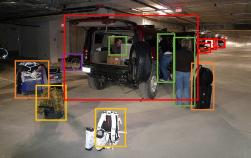

A black SUV is parked in a garage with a person loading luggage into the back.  There are multiple bags and suitcases in the garage.  A second person is standing next to the car.  The garage is empty and has concrete walls.  There are multiple fire extinguishers on the wall.

In [41]:
from utils import plt_img_base64

plt_img_base64(image_base64_list[0])
Markdown(image_summaries[0])

### Add to vectorstore

Add raw docs and doc summaries to [Multi Vector Retriever](https://python.langchain.com/docs/modules/data_connection/retrievers/multi_vector): 

* Store the raw texts, tables, and images in the `docstore`.
* Store the texts, table summaries, and image summaries in the `vectorstore` for efficient semantic retrieval.

In [84]:
import uuid

from langchain_core.documents import Document
from langchain.retrievers.multi_vector import MultiVectorRetriever


def generate_random_ids(
    count: int
) -> list[str]:
    """
    Generates a list of random UUID.

    Args:
        count: Number of random UUID to generate.

    Returns:
        A list of random UUID with length of `count`.
        
    """
    return [
        str(uuid.uuid4()) 
        for _ in range(count)
    ]


def create_documents_from_texts(
    id_key: str,
    texts: list[str],
    doc_ids: list[str],
) -> list[Document]:
    """
    Creates a LangChain `Document` object for each text content.

    Args:
        id_key: Key that is paired with the document ID value.
        texts: List of text contents.
        doc_ids: List of unique IDs for each document.

    Returns:
        List of LangChain `Document` objects.
    
    """
    return [
        Document(
            page_content=text, 
            metadata={
                id_key: doc_ids[index]
            }
        )
        for index, text in enumerate(texts)
    ]


def add_documents(    
    retriever: MultiVectorRetriever, 
    summaries: list[str], 
    contents: list[str],
):
    """
    Add summaries to the vector store and add contents to the
    docstore of the Multi Vector Retriever.
    
    """
    # Generate a unique ID for each Document.
    doc_ids = generate_random_ids(
        count=len(contents)
    )

    # Create a LangChain Document for each summary.
    summary_docs = create_documents_from_texts(
        id_key=retriever.id_key,
        texts=summaries,
        doc_ids=doc_ids
    )
    
    retriever.vectorstore.add_documents(
        documents=summary_docs
    )
    retriever.docstore.mset(
        key_value_pairs=list(
            zip(doc_ids, contents)
        )
    )

In [85]:
from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.storage import InMemoryStore


def create_multi_vector_retriever(
    vector_store, 
    text_summaries, 
    texts, 
    table_summaries, 
    tables, 
    image_summaries, 
    images
):
    """
    Create retriever that indexes summaries, 
    but returns raw images or texts.
    
    """
    # Initialize the storage layer
    mem_store = InMemoryStore()
    id_key = "doc_id"
    
    # Create the multi-vector retriever
    retriever = MultiVectorRetriever(
        vectorstore=vector_store,
        docstore=mem_store,
        id_key=id_key,
    )    

    # Add texts, tables, and images.
    # Check that summaries is not empty before adding.    
    if text_summaries:
        add_documents(            
            retriever, 
            text_summaries, 
            texts
        )  
        
    if table_summaries:
        add_documents(            
            retriever, 
            table_summaries, 
            tables
        )
        
    if image_summaries:
        add_documents(            
            retriever, 
            image_summaries, 
            images
        )

    return retriever

In [65]:
from langchain_chroma import Chroma
from langchain_google_genai import GoogleGenerativeAIEmbeddings


vector_store = Chroma(    
    collection_name="multi_modal_rag", 
    embedding_function=GoogleGenerativeAIEmbeddings(
        model="models/text-embedding-004"
    ),
    persist_directory='data/vector-store',
)

In [72]:
# Create retriever
retriever_multi_vector = create_multi_vector_retriever(
    vector_store,
    text_summaries,
    texts,
    table_summaries,
    tables,
    image_summaries,
    image_base64_list,
)

In [99]:
summary_docs = vector_store.similarity_search(
    query="Visual Intruction Tuning",
    k=1
)
summary_docs[0]

Document(metadata={'doc_id': 'ff8bb037-91a9-4338-9d97-fe6ca333376c'}, page_content="This paper introduces visual instruction-tuning, a novel approach to building a general-purpose visual assistant. It addresses the lack of vision-language instruction-following data by converting image-text pairs into an instruction-following format using ChatGPT/GPT-4. The paper also presents a large multimodal model (LMM) by connecting CLIP's visual encoder with Vicuna's language decoder and fine-tuning it on the generated data. The LMM achieves state-of-the-art performance on the Science QA dataset when combined with GPT-4. Additionally, the paper introduces LLaVA-Bench, a multimodal instruction-following benchmark with challenging tasks, and releases the generated data, codebase, model checkpoints, and a visual chat demo. \n")

In [102]:
# Check retrieval
docs = retriever_multi_vector.invoke(
    input="ramen",     
)

len(docs)

4